<a href="https://colab.research.google.com/github/tortas/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [0]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=38.69323106073592, pvalue=3.961609200867749e-09)


In [0]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [0]:
# Taking requests! Come to lecture with a topic or problem and we'll try it.

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Generally better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
import pandas as pd
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.2}, {:.2}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [0]:
votes = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data",
                    header=None, na_values='?')
votes = votes.replace({'y': 1, 'n': 0})

# Separate dataset into republican and democrats
republican_votes = votes[votes[0] == 'republican']
democrat_votes = votes[votes[0] == 'democrat']

In [9]:
print('Republican votes: ')
for i in range(1,17):
  print('Issue: ', i, report_confidence_interval(confidence_interval(republican_votes[i].dropna())))

Republican votes: 
Issue:  1 our mean lies in the interval [0.13, 0.25]
Issue:  2 our mean lies in the interval [0.43, 0.59]
Issue:  3 our mean lies in the interval [0.081, 0.19]
Issue:  4 our mean lies in the interval [0.97, 1.0]
Issue:  5 our mean lies in the interval [0.92, 0.98]
Issue:  6 our mean lies in the interval [0.85, 0.94]
Issue:  7 our mean lies in the interval [0.17, 0.31]
Issue:  8 our mean lies in the interval [0.096, 0.21]
Issue:  9 our mean lies in the interval [0.066, 0.16]
Issue:  10 our mean lies in the interval [0.48, 0.63]
Issue:  11 our mean lies in the interval [0.079, 0.19]
Issue:  12 our mean lies in the interval [0.82, 0.92]
Issue:  13 our mean lies in the interval [0.81, 0.92]
Issue:  14 our mean lies in the interval [0.96, 1.0]
Issue:  15 our mean lies in the interval [0.044, 0.14]
Issue:  16 our mean lies in the interval [0.58, 0.74]


In [0]:
# Build list of means for plot
r_means = []
r_err = []
d_means = []
d_err = []
for i in range(1,17):
  r = confidence_interval(republican_votes[i].dropna())
  r_means.append(r[0])
  r_err.append((r[2]-r[1])/2)
  
  d = confidence_interval(democrat_votes[i].dropna())
  d_means.append(d[0])
  d_err.append((d[2]-d[1])/2)

In [0]:
import matplotlib.pyplot as plt

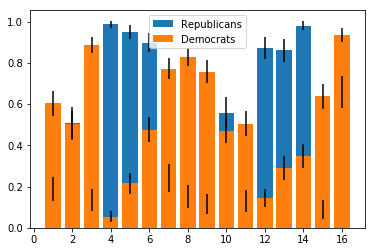

In [42]:
# Republican votes with error bars
fig, ax = plt.subplots()
ax.bar(x=range(1,17), height=r_means, yerr=r_err, label='Republicans');
ax.bar(x=range(1,17), height=d_means, yerr=d_err, label='Democrats');
ax.legend();

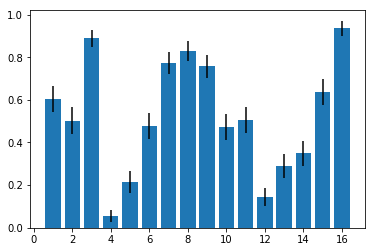

In [33]:
# Democrat votes with error bars
plt.bar(x=range(1,17), height=d_means, yerr=d_err);

In [10]:
print('Democrat votes: ')
for i in range(1,17):
  print('Issue: ', i, report_confidence_interval(confidence_interval(democrat_votes[i].dropna())))

Democrat votes: 
Issue:  1 our mean lies in the interval [0.54, 0.66]
Issue:  2 our mean lies in the interval [0.44, 0.57]
Issue:  3 our mean lies in the interval [0.85, 0.93]
Issue:  4 our mean lies in the interval [0.026, 0.082]
Issue:  5 our mean lies in the interval [0.16, 0.27]
Issue:  6 our mean lies in the interval [0.42, 0.54]
Issue:  7 our mean lies in the interval [0.72, 0.82]
Issue:  8 our mean lies in the interval [0.78, 0.87]
Issue:  9 our mean lies in the interval [0.7, 0.81]
Issue:  10 our mean lies in the interval [0.41, 0.53]
Issue:  11 our mean lies in the interval [0.44, 0.57]
Issue:  12 our mean lies in the interval [0.1, 0.19]
Issue:  13 our mean lies in the interval [0.23, 0.35]
Issue:  14 our mean lies in the interval [0.29, 0.41]
Issue:  15 our mean lies in the interval [0.58, 0.7]
Issue:  16 our mean lies in the interval [0.9, 0.97]


## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)